Download the data

In [ ]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip
!ls

n
--2020-11-05 01:19:56--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.32.207.111, 13.32.207.30, 13.32.207.54, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.32.207.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip.3’

data.zip.3          100%[===================>]   2.75M  --.-KB/s    in 0.01s   

2020-11-05 01:19:56 (250 MB/s) - ‘data.zip.3’ saved [2882130/2882130]

n
Archive:  data.zip
replace data/eng-fra.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace data/names/Arabic.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: char_gru_classification_model.pt   data        data.zip.2
char_lstm_classification_model.pt  data.zip    data.zip.3
char_rnn_classification_model.pt   data.zip.1  sample_data


In [ ]:
%matplotlib inline


Classifying Names with a Character-Level RNN
*********************************************
**Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`_

We will be building and training a basic character-level RNN to classify
words. A character-level RNN reads words as a series of characters -
outputting a prediction and "hidden state" at each step, feeding its
previous hidden state into each next step. We take the final prediction
to be the output, i.e. which class the word belongs to.

Specifically, we'll train on a few thousand surnames from 18 languages
of origin, and predict which language a name is from based on the
spelling:

::

    $ python predict.py Hinton
    (-0.47) Scottish
    (-1.52) English
    (-3.57) Irish

    $ python predict.py Schmidhuber
    (-0.19) German
    (-2.48) Czech
    (-2.68) Dutch


**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  http://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

-  `The Unreasonable Effectiveness of Recurrent Neural
   Networks <http://karpathy.github.io/2015/05/21/rnn-effectiveness/>`__
   shows a bunch of real life examples
-  `Understanding LSTM
   Networks <http://colah.github.io/posts/2015-08-Understanding-LSTMs/>`__
   is about LSTMs specifically but also informative about RNNs in
   general

Preparing the Data
==================

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.

Included in the ``data/names`` directory are 18 text files named as
"[Language].txt". Each file contains a bunch of names, one name per
line, mostly romanized (but we still need to convert from Unicode to
ASCII).

We'll end up with a dictionary of lists of names per language,
``{language: [names ...]}``. The generic variables "category" and "line"
(for language and name in our case) are used for later extensibility.



In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import random

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string
import math

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
train_data = {}
validation_data = {}
test_data = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    random.shuffle(lines)
    train_data[category] = lines[0:int(math.floor(0.7*len(lines)))]
    validation_data[category] = lines[int(math.floor(0.7*len(lines)))+1:int(math.floor(0.85*len(lines)))]
    test_data[category] = lines[int(math.floor(0.85*len(lines)))+1:]
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Vietnamese.txt', 'data/names/Dutch.txt', 'data/names/Italian.txt', 'data/names/Chinese.txt', 'data/names/Russian.txt', 'data/names/German.txt', 'data/names/Greek.txt', 'data/names/Korean.txt', 'data/names/Czech.txt', 'data/names/French.txt', 'data/names/Portuguese.txt', 'data/names/Arabic.txt', 'data/names/Polish.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Japanese.txt', 'data/names/Scottish.txt', 'data/names/Irish.txt']
Slusarski


Now we have ``category_lines``, a dictionary mapping each category
(language) to a list of lines (names). We also kept track of
``all_categories`` (just a list of languages) and ``n_categories`` for
later reference.




In [ ]:
print(category_lines['Italian'][:5])

['Scutese', 'Alunni', 'Alberici', 'Marchioni', 'Cingolani']


Turning Names into Tensors
--------------------------

Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of size
``<1 x n_letters>``. A one-hot vector is filled with 0s except for a 1
at index of the current letter, e.g. ``"b" = <0 1 0 0 0 ...>``.

To make a word we join a bunch of those into a 2D matrix
``<line_length x 1 x n_letters>``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here.




In [ ]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


Creating the Network
====================

Before autograd, creating a recurrent neural network in Torch involved
cloning the parameters of a layer over several timesteps. The layers
held hidden state and gradients which are now entirely handled by the
graph itself. This means you can implement a RNN in a very "pure" way,
as regular feed-forward layers.

This RNN module (mostly copied from `the PyTorch for Torch users
tutorial <http://pytorch.org/tutorials/beginner/former_torchies/
nn_tutorial.html#example-2-recurrent-net>`__)
is just 2 linear layers which operate on an input and hidden state, with
a LogSoftmax layer after the output.

.. figure:: https://i.imgur.com/Z2xbySO.png
   :alt:





In [ ]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
        

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)      

In [ ]:
class LSTM_rnn(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM_rnn, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.LSTMCell(input_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden[0]), 1)
        hidden = self.i2h(input, hidden)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return (torch.zeros(1, self.hidden_size), torch.zeros(1, self.hidden_size))

n_hidden = 128
lstm = LSTM_rnn(n_letters, n_hidden, n_categories)  

In [ ]:
class GRU_rnn(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU_rnn, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.GRUCell(input_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(input, hidden)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


gru = GRU_rnn(n_letters, n_hidden, n_categories)  

To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which we
initialize as zeros at first). We'll get back the output (probability of
each language) and a next hidden state (which we keep for the next
step).




In [ ]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

For the sake of efficiency we don't want to be creating a new Tensor for
every step, so we will use ``lineToTensor`` instead of
``letterToTensor`` and use slices. This could be further optimized by
pre-computing batches of Tensors.




In [ ]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = gru(input[0], hidden)
print(output)

tensor([[-2.8606, -2.9764, -2.8367, -2.9430, -2.9073, -2.9551, -2.9396, -2.9211,
         -2.8666, -2.9258, -2.9131, -2.8969, -2.8381, -2.8372, -2.8354, -2.8033,
         -2.8849, -2.9061]], grad_fn=<LogSoftmaxBackward>)


As you can see the output is a ``<1 x n_categories>`` Tensor, where
every item is the likelihood of that category (higher is more likely).




Training
========
Preparing for Training
----------------------

Before going into training we should make a few helper functions. The
first is to interpret the output of the network, which we know to be a
likelihood of each category. We can use ``Tensor.topk`` to get the index
of the greatest value:




In [ ]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Japanese', 15)


We will also want a quick way to get a training example (a name and its
language):




In [ ]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(train_data[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Chinese / line = Tian
category = Russian / line = Janovitsky
category = Vietnamese / line = Than
category = Greek / line = Manoukarakis
category = Scottish / line = Mackay
category = Vietnamese / line = Ly
category = Scottish / line = Davidson
category = Portuguese / line = Albuquerque
category = Vietnamese / line = Than
category = Greek / line = Lillis


Training the Network
--------------------

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it's wrong.

For the loss function ``nn.NLLLoss`` is appropriate, since the last
layer of the RNN is ``nn.LogSoftmax``.




In [ ]:
criterion = nn.NLLLoss()

Each loop of training will:

-  Create input and target tensors
-  Create a zeroed initial hidden state
-  Read each letter in and

   -  Keep hidden state for next letter

-  Compare final output to target
-  Back-propagate
-  Return the output and loss




In [ ]:
optimizer_rnn = torch.optim.Adam(rnn.parameters())
optimizer_gru = torch.optim.Adam(gru.parameters())
optimizer_lstm = torch.optim.Adam(lstm.parameters())

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    hidden_gru = gru.initHidden()
    hidden_lstm = lstm.initHidden()

    # reset gradient
    rnn.zero_grad()
    gru.zero_grad()
    lstm.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        output_gru, hidden_gru = gru(line_tensor[i], hidden_gru)
        output_lstm, hidden_lstm = lstm(line_tensor[i], hidden_lstm)

    loss = criterion(output, category_tensor)
    loss_gru = criterion(output_gru, category_tensor)
    loss_lstm = criterion(output_lstm, category_tensor)
    
    loss.backward()
    loss_gru.backward()
    loss_lstm.backward()
    # update parameters
    optimizer_rnn.step()
    optimizer_gru.step()
    optimizer_lstm.step()

    return [(output, loss.item()), (output_gru, loss_gru.item()), (output_lstm, loss_lstm.item())]

Now we just have to run that with a bunch of examples. Since the
``train`` function returns both the output and loss we can print its
guesses and also keep track of loss for plotting. Since there are 1000s
of examples we print only every ``print_every`` examples, and take an
average of the loss.




In [ ]:
import time
import math

n_iters = 80000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
train_loss_rnn = 0
train_loss_gru = 0
train_loss_lstm= 0
all_train_losses_rnn = []
all_train_losses_gru = []
all_train_losses_lstm = []
all_validation_losses_rnn = []
all_validation_losses_gru = []
all_validation_losses_lstm = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()
    hidden_gru = gru.initHidden()
    hidden_lstm = lstm.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        output_gru, hidden_gru = gru(line_tensor[i], hidden_gru)
        output_lstm, hidden_lstm = lstm(line_tensor[i], hidden_lstm)
    return (output, output_gru, output_lstm)

def eval_dataset(dataset):
    loss_rnn = 0
    loss_gru = 0
    loss_lstm = 0
    n_instances = 0
    confusion_rnn = torch.zeros(n_categories, n_categories)
    confusion_gru = torch.zeros(n_categories, n_categories)
    confusion_lstm = torch.zeros(n_categories, n_categories)
    for category in all_categories:
        category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
        n_instances += len(dataset[category])
        for line in dataset[category]:
            line_tensor = Variable(lineToTensor(line))
            outputs = evaluate(line_tensor)
            
            output_rnn = outputs[0]
            output_gru = outputs[1]
            output_lstm = outputs[2]

            loss_rnn += criterion(output_rnn, category_tensor)
            loss_gru += criterion(output_gru, category_tensor)
            loss_lstm += criterion(output_lstm, category_tensor)
            guess_rnn, guess_i_rnn = categoryFromOutput(output_rnn)
            category_i = all_categories.index(category)
            confusion_rnn[category_i][guess_i_rnn] += 1
            guess_gru, guess_i_gru = categoryFromOutput(output_gru)
            confusion_gru[category_i][guess_i_gru] += 1
            guess_lstm, guess_i_lstm = categoryFromOutput(output_lstm)
            confusion_lstm[category_i][guess_i_lstm] += 1

    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion_rnn[i] = confusion_rnn[i] / confusion_rnn[i].sum()
        confusion_gru[i] = confusion_gru[i] / confusion_gru[i].sum()
        confusion_lstm[i] = confusion_lstm[i] / confusion_lstm[i].sum()

    return [(loss_rnn.item() / n_instances, confusion_rnn), 
            (loss_gru.item() / n_instances, confusion_gru), 
            (loss_lstm.item() / n_instances, confusion_lstm)]
  
print('\nIter \tTrain% \tTime \t\tTrain_loss \tExample')
start = time.time()
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    results = train(category_tensor, line_tensor)
    output_linear, loss_linear = results[0]
    output_gru, loss_gru = results[1]
    output_lstm, loss_lstm = results[2]
    train_loss_rnn += loss_linear
    train_loss_gru += loss_gru
    train_loss_lstm += loss_lstm

    # Print iter number, train loss average, name and guess
    if iter % print_every == 0:
        guess_rnn, guess_i = categoryFromOutput(output_linear)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('RNN %d \t%d%% \t(%s) \t%.4f \t\t%s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), train_loss_rnn / plot_every, line, guess_rnn, correct))
        guess_gru, guess_i = categoryFromOutput(output_gru)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('GRU %d \t%d%% \t(%s) \t%.4f \t\t%s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), train_loss_gru / plot_every, line, guess_gru, correct))
        guess_lstm, guess_i = categoryFromOutput(output_lstm)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('LSTM %d \t%d%% \t(%s) \t%.4f \t\t%s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), train_loss_lstm / plot_every, line, guess_lstm, correct))

    # Add current train loss average to list of losses
    if iter % plot_every == 0:
        all_train_losses_rnn.append(train_loss_rnn/ plot_every)
        all_train_losses_gru.append(train_loss_gru / plot_every)
        all_train_losses_lstm.append(train_loss_lstm / plot_every)
        train_loss_rnn = 0
        train_loss_gru = 0
        train_loss_lstm = 0
        
    # Compute loss based on validation data
    if iter % plot_every == 0:
        average_validation_loss = eval_dataset(validation_data)
        avg_validation_loss_rnn = average_validation_loss[0][0]
        avg_validation_loss_gru = average_validation_loss[1][0]
        avg_validation_loss_lstm = average_validation_loss[2][0]

        # save model with best validation loss
        if len(all_validation_losses_rnn) == 0 or avg_validation_loss_rnn < min(all_validation_losses_rnn):
            torch.save(rnn, 'char_rnn_classification_model.pt')
        if len(all_validation_losses_gru) == 0 or avg_validation_loss_gru < min(all_validation_losses_gru):
            torch.save(gru, 'char_gru_classification_model.pt')
        if len(all_validation_losses_lstm) == 0 or avg_validation_loss_lstm < min(all_validation_losses_lstm):
            torch.save(lstm, 'char_lstm_classification_model.pt')
        all_validation_losses_rnn.append(avg_validation_loss_rnn)
        all_validation_losses_gru.append(avg_validation_loss_gru)
        all_validation_losses_lstm.append(avg_validation_loss_lstm)



Iter 	Train% 	Time 		Train_loss 	Example
RNN 5000 	6% 	(1m 22s) 	1.7994 		Bencivenni / Italian ✗ (Italian)
GRU 5000 	6% 	(1m 22s) 	1.5679 		Bencivenni / Italian ✗ (Italian)
LSTM 5000 	6% 	(1m 22s) 	1.6574 		Bencivenni / Italian ✗ (Italian)
RNN 10000 	12% 	(2m 57s) 	1.5919 		Schwenke / Czech ✗ (German)
GRU 10000 	12% 	(2m 57s) 	1.2917 		Schwenke / German ✗ (German)
LSTM 10000 	12% 	(2m 57s) 	1.3910 		Schwenke / German ✗ (German)
RNN 15000 	18% 	(4m 31s) 	1.5227 		Japaskurt / Dutch ✗ (Russian)
GRU 15000 	18% 	(4m 31s) 	1.0222 		Japaskurt / Dutch ✗ (Russian)
LSTM 15000 	18% 	(4m 31s) 	1.1261 		Japaskurt / Dutch ✗ (Russian)
RNN 20000 	25% 	(6m 5s) 	1.3847 		John / Korean ✗ (Irish)
GRU 20000 	25% 	(6m 5s) 	0.8468 		John / Korean ✗ (Irish)
LSTM 20000 	25% 	(6m 5s) 	0.9261 		John / Korean ✗ (Irish)
RNN 25000 	31% 	(7m 38s) 	1.3645 		Quirke / Japanese ✗ (Irish)
GRU 25000 	31% 	(7m 38s) 	0.7083 		Quirke / English ✗ (Irish)
LSTM 25000 	31% 	(7m 38s) 	0.8060 		Quirke / English ✗ (Irish)
RNN 3000

Plotting the Results
--------------------

Plotting the historical loss from ``all_losses`` shows the network
learning:




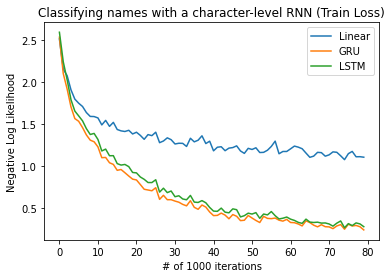

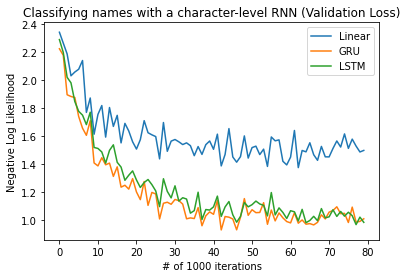

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_train_losses_rnn)
plt.plot(all_train_losses_gru)
plt.plot(all_train_losses_lstm)
plt.title('Classifying names with a character-level RNN (Train Loss)')
plt.ylabel('Negative Log Likelihood')
plt.xlabel('# of 1000 iterations')
plt.legend(['Linear', 'GRU', 'LSTM'], loc='upper right')


plt.figure()
plt.plot(all_validation_losses_rnn)
plt.plot(all_validation_losses_gru)
plt.plot(all_validation_losses_lstm)
plt.title('Classifying names with a character-level RNN (Validation Loss)')
plt.ylabel('Negative Log Likelihood')
plt.xlabel('# of 1000 iterations')
plt.legend(['Linear', 'GRU', 'LSTM'], loc='upper right')


Evaluating the Results
======================

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with
``evaluate()``, which is the same as ``train()`` minus the backprop.




RNN Average test loss: 1.3558658344353964


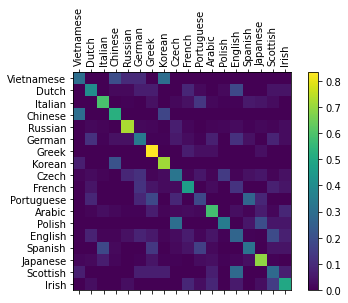

In [ ]:
# evaluate on test set and display confusion matrix RNN
rnn = torch.load('char_rnn_classification_model.pt')

confusions = eval_dataset(test_data)
rnn_avg_test_loss, rnn_confusions = confusions[0]
gru_avg_test_loss, gru_confusions = confusions[1]
lstm_avg_test_loss, lstm_confusions = confusions[2]
print('RNN Average test loss: ' + str(rnn_avg_test_loss))

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(rnn_confusions.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

GRU Average test loss: 0.9380353033363878


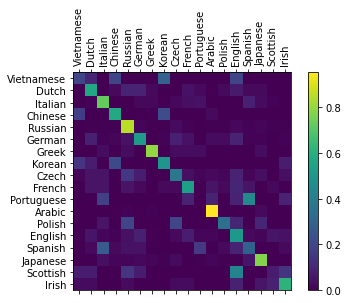

In [ ]:
gru = torch.load('char_gru_classification_model.pt')

print('GRU Average test loss: ' + str(gru_avg_test_loss))

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(gru_confusions.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

LSTM Average test loss: 0.984850752874042


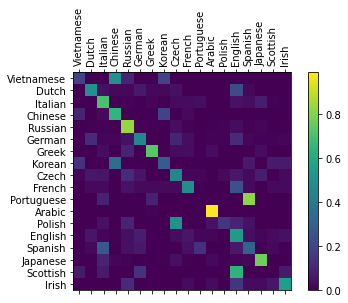

In [ ]:
lstm = torch.load('char_lstm_classification_model.pt')
print('LSTM Average test loss: ' + str(lstm_avg_test_loss))
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(lstm_confusions.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

# Explanation

GRU has the lowest average test loss, LSTM has the second lowest average test loss and the basic RNN has the highest average test lost. The same goes for the training and validation dataset. The basic RNN suffers from vanishing and exploding gradient problems.  LSTM performs better than the basic RNN because it controls memorization and forgetting in RNN, mitigates gradient vanishing and facilitate long term memory. Similarly, GRU also uses gates -- update and reset gates. Although GRU is more efficient computationally as it uses less gates than LSTM and doesn't have a cell state. Both GRU and LSTM perform similarly. Although LSTM might work better on longer sequences.